In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from dmrgwaytorho import *
from scipy import integrate,special
from scipy.linalg import eig,eigh,eigvals,eigvalsh
from scipy.sparse.linalg import eigs
import pickle 
from functions import doApplyHam,isingmodel,diagonalize
from functions import isingmodel_rev,isingmodel_rev_frac2,construct_ham
import itertools as it
import qutip as q

In [2]:
def func1(phi,l,lamb):
    
    part1=(lamb-np.cos(phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
    
    return part1*np.cos(l*phi)/np.pi

def func2(phi,l,lamb):
    
    part2=(np.sin(phi))/np.sqrt(1+lamb**2-2*lamb*np.cos(phi))
    
    return -part2*np.sin(l*phi)/np.pi

def gfunc(l,lamb):
    
    integ1=integrate.quad(func1,0,np.pi,args=(l,lamb))
    integ2=integrate.quad(func2,0,np.pi,args=(l,lamb))
    
    return integ1[0]-integ2[0]
def g_s(lambdas):

    g={}
    for n in range(-L,L): 
        for l in lambdas:
            g[n,l]=gfunc(n,l)
    return g

def assign_g(a,b,g,lamb):
    if a==b:
        return 0
    d=b-a 
    if d%2==1:
        if a%2==1:
            return 1j*g[(d-1)//2,lamb]
        elif a%2==0:
            
            return -1j*g[-((d+1)//2),lamb]
    else:
        return 0
    
def assign_g_debug(a,b):
    if a==b:
        return 0
    d=b-a 
    if d%2==1:
        if a%2==1:
            return "ig[{}]".format((d-1)//2)
        elif a%2==0:
            
            return "-ig[{}]".format(-(d+1)//2)
    else:
        return 0

def get_mat(gdic,lam):
    mat = [[None for c in range(1,2*L+1)] for r in range(1,2*L+1)]
    for x in range(1,2*L+1):
        for y in range(1,2*L+1):
            mat[x-1][y-1]=assign_g(x,y,gdic,lam)  
    return np.array(mat)

In [3]:
L=2
lambdarange=np.linspace(0.1,2)

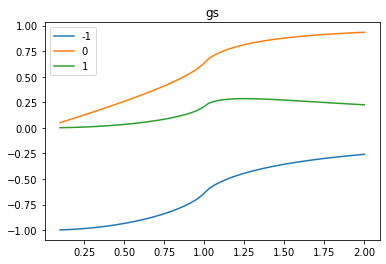

In [4]:
fig,ax=plt.subplots()
for size in range(-L+1,L):
    temp_vec=np.zeros_like(lambdarange)
    for i,lam in enumerate(lambdarange):
        temp_vec[i]=gfunc(size,lam)
    ax.plot(lambdarange,temp_vec,label=size)
plt.title("gs")
plt.legend()
plt.show()

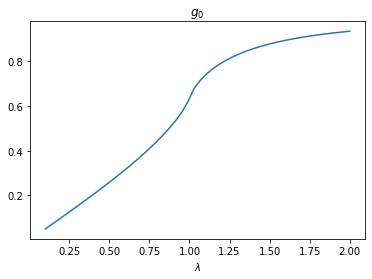

In [5]:
temp_vec=np.zeros_like(lambdarange)
for i,lam in enumerate(lambdarange):
    temp_vec[i]=gfunc(0,lam)
plt.plot(lambdarange,temp_vec)
plt.title(r"$g_0$")
plt.xlabel(r"$\lambda$")
plt.show()

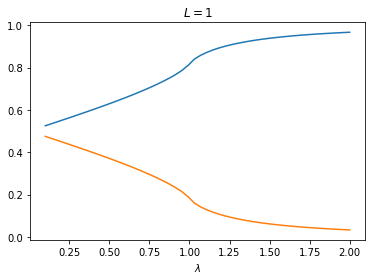

In [6]:
lam1=np.zeros_like(lambdarange)
lam2=np.zeros_like(lambdarange)
for i,lam in enumerate(lambdarange):
    lam1[i]=(1+gfunc(0,lam))/2
    lam2[i]=(1-gfunc(0,lam))/2
plt.plot(lambdarange,lam1)
plt.plot(lambdarange,lam2)
plt.title(r"$L=1$")
plt.xlabel(r"$\lambda$")
plt.savefig("L1_lambda")
plt.show()

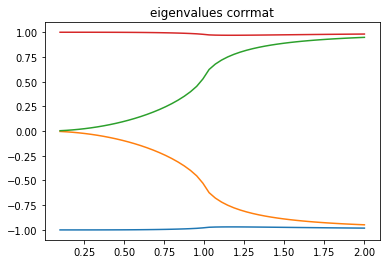

In [7]:
gdic=g_s(lambdarange)
autov={}
for i,x in enumerate(lambdarange):
    matr=get_mat(gdic,x)
    autov[i]=eigvalsh(matr)
    
autovals=np.array([autov[i] for i in autov])
plt.plot(lambdarange,autovals)
plt.title("eigenvalues corrmat")
plt.show()
#questi sono nu1,nu2,-nu2,-nu1

to build eigenvalues of the reduced density matrix we make all the prods (1+nu1)/2*(1+nu2)/2*.., (1+nu1)(1-nu2)...

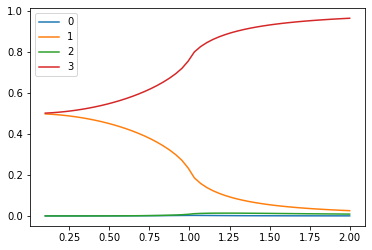

In [8]:

nus=autovals[:,L:]

eigrho={}
for j,sign in enumerate(it.product((range(-1,2,2)),repeat=L)):
    signarr=np.array(sign)
    for i,row in enumerate(nus):
        rowsign=np.array([(1+signarr[n]*row[n])/2 for n in range(L)])
        eigrho[i,j]=np.prod(rowsign)
for k in range(2**L):
    temp_eigs=[]
    temp_eigs=[eigrho[x,k] for x in range(len(lambdarange))]
    plt.plot(lambdarange,temp_eigs,label=k)
    plt.legend()


In [9]:
length=10
h=0.0001
dictionary_open0_h1={}

for l in lambdarange:

    Energies,psis=diagonalize(1,length,isingmodel_rev_frac2(l,h),False)

    qpsi=q.Qobj(psis[:,0],dims=[[2]*length,[1]*length])   

    rhomagn0=qpsi.ptrace(range(int((length-L)/2),int((length+L)/2)))

    dictionary_open0_h1[l,L]=rhomagn0

[2.36638520e-04 8.89039348e-03 2.56905753e-02 9.65182393e-01]


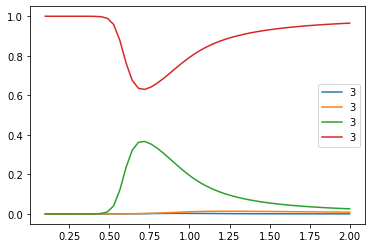

In [10]:
temp_eigs=[dictionary_open0_h1[x,L].eigenenergies() for x in lambdarange]
plt.plot(lambdarange,temp_eigs,label=k)
plt.legend()

eigvals_exp=dictionary_open0_h1[x,L].eigenenergies()
print(eigvals_exp)

In [11]:
length=10
h=0.00
dictionary_open0_h1={}

for l in lambdarange:

    Energies,psis=diagonalize(1,length,isingmodel_rev_frac2(l,h),False)

    qpsi=q.Qobj(psis[:,0],dims=[[2]*length,[1]*length])   

    rhomagn0=qpsi.ptrace(range(int((length-L)/2),int((length+L)/2)))

    dictionary_open0_h1[l,L]=rhomagn0

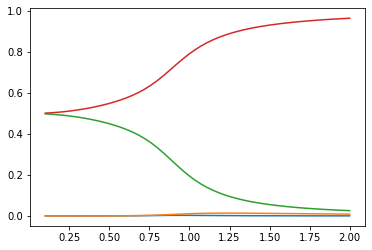

In [12]:
exp_eigs=[dictionary_open0_h1[x,L].eigenenergies() for x in lambdarange]
plt.plot(lambdarange,exp_eigs)
eigvals_exp=dictionary_open0_h1[x,L].eigenenergies()


Now we can calculate all the quantity theoretically with the eigenvalues